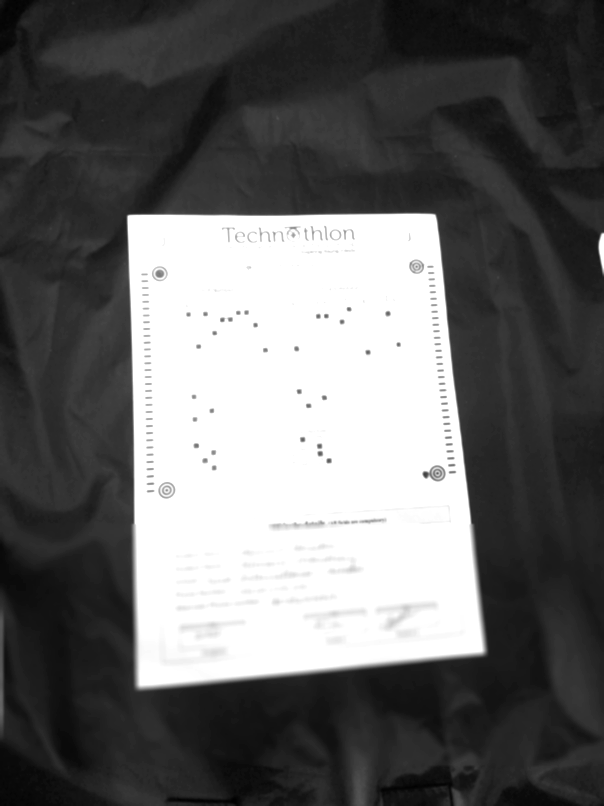

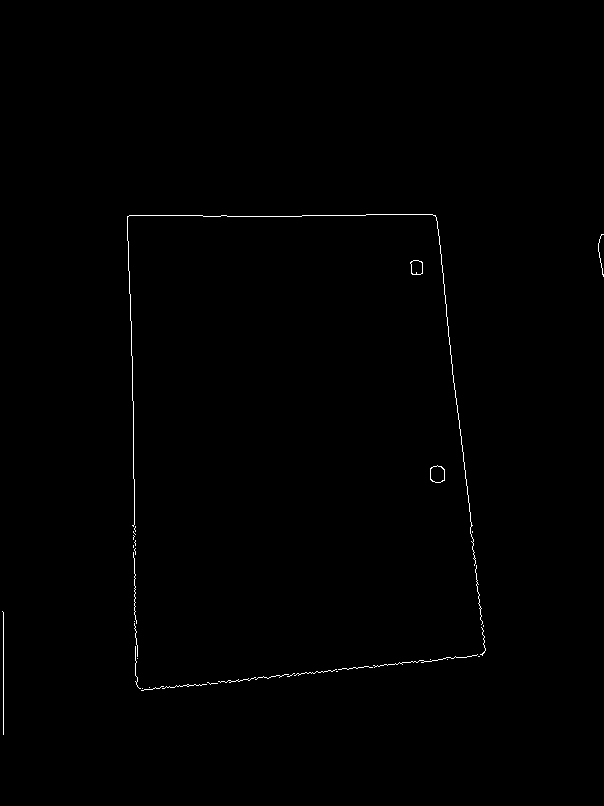

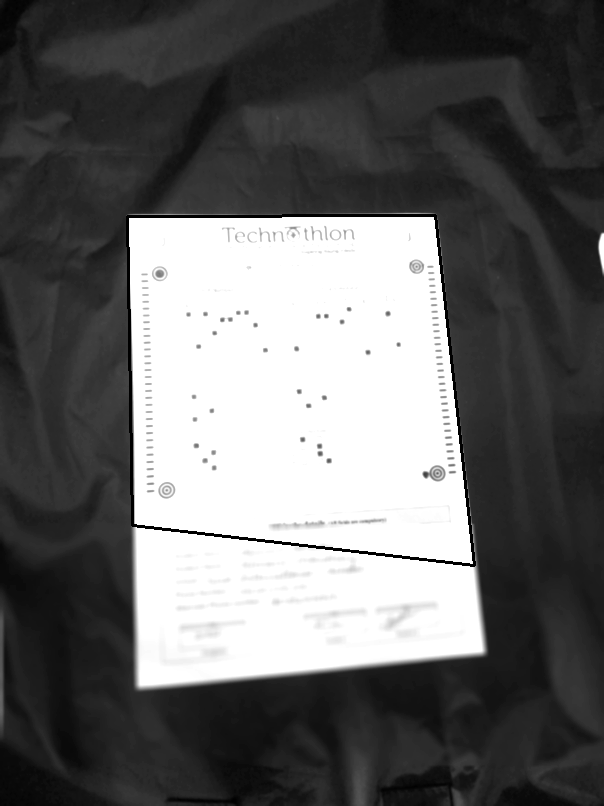

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:165: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


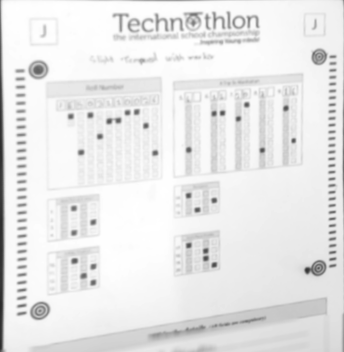

In [4]:

import cv2
import numpy as np
from IPython.display import display
from PIL import Image
from matplotlib import pyplot as plt
MIN_PAGE_AREA = 80000
def normalize(image):
    return cv2.normalize(image, 0, 255, norm_type=cv2.NORM_MINMAX)
def grab_contours(cnts):
        # source: imutils package

        # if the length the contours tuple returned by cv2.findContours
        # is '2' then we are using either OpenCV v2.4, v4-beta, or
        # v4-official
        if len(cnts) == 2:
            cnts = cnts[0]

        # if the length of the contours tuple is '3' then we are using
        # either OpenCV v3, v4-pre, or v4-alpha
        elif len(cnts) == 3:
            cnts = cnts[1]

        # otherwise OpenCV has changed their cv2.findContours return
        # signature yet again and I have no idea WTH is going on
        else:
            raise Exception(
                (
                    "Contours tuple must have length 2 or 3, "
                    "otherwise OpenCV changed their cv2.findContours return "
                    "signature yet again. Refer to OpenCV's documentation "
                    "in that case"
                )
            )

        # return the actual contours array
        return cnts
def find_page( image):
        # Done: find ORIGIN for the quadrants
        # Done, Auto tune! : Get canny parameters tuned

        image = normalize(image)
        # Assumes white pages -
        _ret, image = cv2.threshold(image, 200, 255, cv2.THRESH_TRUNC)
        image =normalize(image)

        # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 10))
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 10))

        # Closing is reverse of Opening, Dilation followed by Erosion.
        # A pixel in the original image (either 1 or 0) will be considered 1 only
        # if all the pixels under the kernel is 1, otherwise it is eroded (made to zero).

        # Close the small holes, i.e. Complete the edges on canny image
        closed = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

        # TODO: Parametrize this from template config
        edge = cv2.Canny(closed, 185, 55)

        # findContours returns outer boundaries in CW and inner boundaries in ACW
        # order.
        cnts = grab_contours(
            cv2.findContours(edge, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        )
        # hullify to resolve disordered curves due to noise
        cnts = [cv2.convexHull(c) for c in cnts]
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]
        sheet = []
        for c in cnts:
            if cv2.contourArea(c) < MIN_PAGE_AREA:
                continue
            peri = cv2.arcLength(c, True)
            # ez algo -
            # https://en.wikipedia.org/wiki/Ramer–Douglas–Peucker_algorithm
            approx = cv2.approxPolyDP(c, epsilon=0.025 * peri, closed=True)
            # print("Area",cv2.contourArea(c), "Peri", peri)

            # check its rectangle-ness:
            # if validate_rect(approx)
            if True:
                sheet = np.reshape(approx, (4, -1))
                display(Image.fromarray(image))
                cv2.drawContours(image, [approx], -1, (0,255, 0), 2)
                display(Image.fromarray(edge))
                cv2.drawContours(edge, [approx], -1, (255, 255, 255), 10)
                display(Image.fromarray(image))
                break
        # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # plt.imshow(edge)
        # plt.title('my picture')
        # plt.show()
        
        #cv2.waitKey(0)
            # box = perspective.order_points(box)
        # sobel = cv2.addWeighted(cv2.Sobel(edge, cv2.CV_64F, 1, 0, ksize=3),
        #           0.5,cv2.Sobel(edge, cv2.CV_64F, 0, 1, ksize=3),0.5,0,edge)

        # ExcessDo : make it work on killer images
        # edge2 = auto_canny(image_norm)
        # show('Morphed Edges',np.hstack((closed,edge)),1,1)

        return sheet
# path="samples/sample1/MobileCamera/sheet1.jpg"
# display(Image.open(path))
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    width_a = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_b = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))

    max_width = max(int(width_a), int(width_b))
    # max_width = max(int(np.linalg.norm(br-bl)), int(np.linalg.norm(tr-tl)))

    # compute the height of the new image, which will be the
    height_a = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_b = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height_a), int(height_b))
    # max_height = max(int(np.linalg.norm(tr-br)), int(np.linalg.norm(tl-br)))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array(
        [
            [0, 0],
            [max_width - 1, 0],
            [max_width - 1, max_height - 1],
            [0, max_height - 1],
        ],
        dtype="float32",
    )

    transform_matrix = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, transform_matrix, (max_width, max_height))

    # return the warped image
    return warped

def apply_filter(image):
        
        # TODO: Take this out into separate preprocessor
        image = normalize(cv2.GaussianBlur(image, (3, 3), 0))
        # Resize should be done with another preprocessor is needed
        sheet = find_page(image)
        if sheet == []:
            logger.error(
                "\tError: Paper boundary not found! \
                Have you accidentally included CropPage preprocessor?"
            )
            return None
        # cv2.waitKey(0)
        # Warp layer 1
        image = four_point_transform(image, sheet)
        

        # Return preprocessed image
        return image
image =cv2.imread("samples/sample1/MobileCamera/sheet1.jpg", cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, None, fx = 0.65, fy = 0.65)
display(Image.fromarray(apply_filter( image)))